In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import time
import warnings

from datetime import datetime
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNetCV, ElasticNet
from sklearn.feature_selection import SelectKBest, RFE,RFECV, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
# Suppress Warning message

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    

def log_msg(message):
    print(str(datetime.now()) + ": " + message)


## Load data

In [3]:
train_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

## Feature Selection
### Drop the missing values

In [4]:
# Drop columns with more than 80% of missing values

missing_val_df=(train_df.isnull().sum() / len(train_df)).sort_values(ascending=False)
missing_features = missing_val_df[missing_val_df > 0.80].index
train_df.drop(missing_features, axis=1, inplace=True)


train_df["FireplaceQu"].fillna("NA", inplace = True)

(train_df.isnull().sum() / len(train_df)).sort_values(ascending=False)

LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
                  ...   
BsmtUnfSF       0.000000
TotalBsmtSF     0.000000
MSSubClass      0.000000
HeatingQC       0.000000
SalePrice       0.000000
Length: 77, dtype: float64

In [5]:
# Drop the rest of the rows with null values
train_df.dropna(inplace = True)

###  Drop the zero variance columns

In [6]:
# remove coloumns with constant values
train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()] 
print(train_df.shape)

(1094, 76)


### Correlation analysis
#### Correlation among the features

In [7]:
train_df_nid = train_df.drop(['Id'],axis=1)

# Create correlation matrix
corr_matrix = train_df_nid.drop(['SalePrice'],axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# select one feature from the highly correlated features, threshold 0.6
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

print(to_drop)

# drop the selected feattures that are correlated with anothoer feature
train_df_nid.drop(to_drop, axis=1, inplace=True)

['YearRemodAdd', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea']


#### Correlation with the target Variable

In [8]:
corr_with_tot_count = train_df_nid.corr()["SalePrice"].sort_values(ascending=False)
feature_x_cont= corr_with_tot_count.index.tolist()
item_list = ['3SsnPorch', 'LowQualFinSF', 'YrSold'] # Remove these since there is low correlation to the target variable
num_features = [ elem for elem in feature_x_cont if elem not in item_list]

df_cont = train_df[num_features]

In [9]:
# find the catergorical coloumns 
cats = train_df.select_dtypes(include=['object']).columns.to_list()
df_cat = train_df[cats].copy()

# Convert to Pandas category
for col in cats:
    df_cat[col] = df_cat[col].astype('category')

In [10]:
# Creating the Final data with all the relevant fields and Dep Variable
train_df_new = pd.concat([df_cat,
                       df_cont],axis=1)

train_df_new.head(3)

,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,...,ScreenPorch,PoolArea,MoSold,MiscVal,BsmtFinSF2,BsmtHalfBath,MSSubClass,KitchenAbvGr,OverallCond,EnclosedPorch
0,RL,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,...,0,0,2,0,0,0,60,1,5,0
1,RL,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,...,0,0,5,0,0,1,20,1,8,0
2,RL,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,...,0,0,9,0,0,0,60,1,5,0


In [11]:
train_df_new.dtypes

MSZoning         category
Street           category
LotShape         category
LandContour      category
LotConfig        category
                   ...   
BsmtHalfBath        int64
MSSubClass          int64
KitchenAbvGr        int64
OverallCond         int64
EnclosedPorch       int64
Length: 62, dtype: object

### Training and Testing data seperation

In [12]:
# Creating Training and Test data
from sklearn.model_selection import train_test_split
df = train_df_new.copy()
Y_train=df['SalePrice'].values.ravel()
X_train = df.drop(['SalePrice'],axis=1)

x_train,x_test,y_train,y_test = train_test_split(X_train,Y_train,train_size = 0.7,random_state=3)

In [13]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(765, 61) (329, 61) (765,) (329,)


## Model training - with initial feature selection

In [14]:
dtrain_reg = xgb.DMatrix(x_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(x_test, y_test, enable_categorical=True)

In [15]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "hist"}

n = 100
model = xgb.train(params=params,dtrain=dtrain_reg,num_boost_round=n,)
preds = model.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 33874.115


In [16]:
n=5000
evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
    verbose_eval=50,
   # Activate early stopping
   early_stopping_rounds=50
)

[0]	validation-rmse:152640.36584	train-rmse:145733.79216
[50]	validation-rmse:33851.05899	train-rmse:2443.88668
[100]	validation-rmse:33873.82426	train-rmse:458.61559
[150]	validation-rmse:33867.71482	train-rmse:88.91092
[200]	validation-rmse:33868.94319	train-rmse:18.72635
[250]	validation-rmse:33868.38457	train-rmse:4.13312
[300]	validation-rmse:33868.37866	train-rmse:0.90848
[350]	validation-rmse:33868.38414	train-rmse:0.19081
[400]	validation-rmse:33868.38455	train-rmse:0.05722
[450]	validation-rmse:33868.38494	train-rmse:0.04747
[490]	validation-rmse:33868.38494	train-rmse:0.04747


In [17]:
preds = model.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the improved model: {rmse:.3f}")

RMSE of the improved model: 33868.385


In [18]:
n = 1000
results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20)

In [19]:
best_rmse = results['test-rmse-mean'].min()
best_rmse

35317.21338505782

In [20]:
x=model.get_score(importance_type='gain')

#{k: v for k, v in sorted(x.items(), key=lambda item: item[1])}

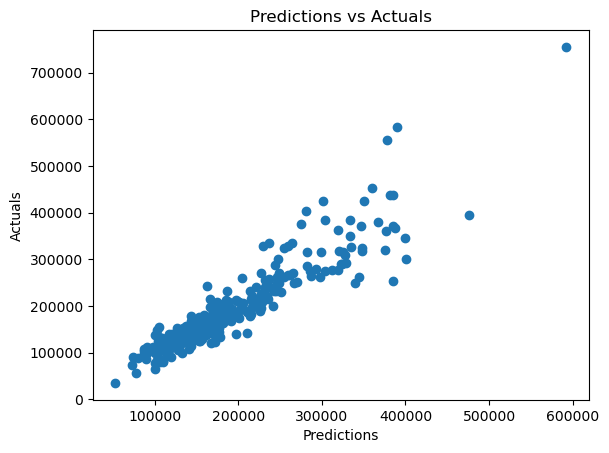

In [21]:
plt.scatter(preds,y_test)
plt.title("Predictions vs Actuals")
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.show()

## Model improvements
### Decision Tree based feature selection

In [22]:
# Converting the categorical variables using dummy variable encoding
object_cols={}
for col_name in df_cat.columns:
    pref = "{}{}".format(col_name[0:2], col_name[-2:])
    new_col = pd.get_dummies(df_cat[col_name], prefix=pref) 
    object_cols["d_" + pref] = new_col

# create final dataframe using all the converted colomuns
all_cat_df=pd.concat(object_cols.values(), axis=1)    

In [23]:
train_df_sel_feat = pd.concat([all_cat_df,
                       df_cont],axis=1)

train_df_sel_feat.head(3)


,MSng_C (all),MSng_FV,MSng_RH,MSng_RL,MSng_RM,Stet_Grvl,Stet_Pave,Lope_IR1,Lope_IR2,Lope_IR3,...,ScreenPorch,PoolArea,MoSold,MiscVal,BsmtFinSF2,BsmtHalfBath,MSSubClass,KitchenAbvGr,OverallCond,EnclosedPorch
0,0,0,0,1,0,0,1,0,0,0,...,0,0,2,0,0,0,60,1,5,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,5,0,0,1,20,1,8,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,9,0,0,0,60,1,5,0


In [24]:
# Creating Training and Test data

new_df = train_df_sel_feat.copy()
Y_train_new=new_df['SalePrice'].values.ravel()
X_train_new = new_df.drop(['SalePrice'],axis=1)

In [25]:
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train_new, Y_train_new)
# get importance
importance = model.feature_importances_
# summarize feature importance
impList = dict(zip(X_train_new.columns, importance))

In [26]:
data= {'Feature': X_train_new.columns, "import" : importance } 
imp_data = pd.DataFrame(data)

sel_feat_df_DT = imp_data.loc[imp_data['import']>0.000848].sort_values(by='import', ascending=False).reset_index(drop=True)
sel_feat_df_DT.head(3)

,Feature,import
0,OverallQual,0.661326
1,2ndFlrSF,0.110051
2,TotalBsmtSF,0.051408


In [27]:
sel_feat_df_DT.nlargest(40,'import')

,Feature,import
0,OverallQual,0.661326
1,2ndFlrSF,0.110051
2,TotalBsmtSF,0.051408
3,LotFrontage,0.022480
4,BsmtFinSF1,0.019799
5,BsmtUnfSF,0.012489
6,LotArea,0.011670
7,YearBuilt,0.007482
8,Mape_Stone,0.007209
9,ScreenPorch,0.006892


In [28]:
# select different features from the training data based on the features selected by different feature selection methods
def selelec_data(x_train,x_test, sel_df):
    x_train_new = x_train[x_train.columns.intersection(sel_df['Feature'])]
    x_test_new = x_test[x_test.columns.intersection(sel_df['Feature'])]

    return x_train_new,x_test_new

In [29]:
x_train_new,x_test_new = selelec_data(x_train,x_test, sel_feat_df_DT)

In [30]:
dtrain_reg_new = xgb.DMatrix(x_train_new, y_train, enable_categorical=True)
dtest_reg_new = xgb.DMatrix(x_test_new, y_test, enable_categorical=True)

In [31]:
n=5000
evals_2 = [(dtest_reg_new, "validation"), (dtrain_reg_new, "train")]
model_2 = xgb.train(
   params=params,
   dtrain=dtrain_reg_new,
   num_boost_round=n,
   evals=evals_2,
    verbose_eval=50,
   # Activate early stopping
   early_stopping_rounds=50
)

[0]	validation-rmse:152920.59953	train-rmse:145810.89899
[50]	validation-rmse:32510.33642	train-rmse:3724.68081
[100]	validation-rmse:32575.11132	train-rmse:899.09111
[150]	validation-rmse:32575.60244	train-rmse:254.72499
[200]	validation-rmse:32578.65891	train-rmse:76.36436
[250]	validation-rmse:32580.19144	train-rmse:21.25114
[300]	validation-rmse:32579.77335	train-rmse:6.15988
[350]	validation-rmse:32579.74379	train-rmse:1.92346
[400]	validation-rmse:32579.78180	train-rmse:0.49319
[450]	validation-rmse:32579.76849	train-rmse:0.14280
[500]	validation-rmse:32579.76577	train-rmse:0.07023
[550]	validation-rmse:32579.76574	train-rmse:0.05945
[588]	validation-rmse:32579.76574	train-rmse:0.05950


In [32]:
preds_2 = model_2.predict(dtest_reg_new)
rmse_2 = mean_squared_error(y_test, preds_2, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 33868.385


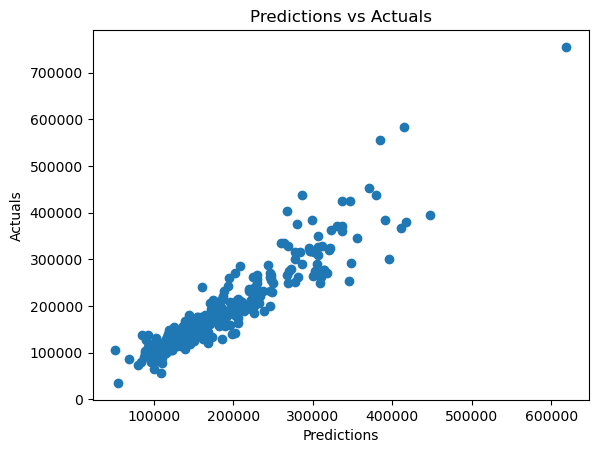

In [33]:
plt.scatter(preds_2,y_test)
plt.title("Predictions vs Actuals")
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.show()

### Mutual info regression

In [34]:
df = train_df_sel_feat.copy()

Y_train=df['SalePrice'].values.ravel()
X_train = df.drop(['SalePrice'],axis=1)


selector = SelectKBest(mutual_info_regression, k=50)
X_train_new = selector.fit_transform(X_train, Y_train) 

#to get names of the selected features
mask = selector.get_support()     
   

new_features = X_train.columns[mask]
print(new_features)  

Index(['MSng_RL', 'MSng_RM', 'Lope_IR1', 'Lope_Reg', 'Neod_NAmes',
       'Neod_NridgHt', 'Hole_2Story', 'Exst_VinylSd', 'Mape_None', 'Exal_Ex',
       'Exal_Gd', 'Exal_TA', 'Foon_CBlock', 'Foon_PConc', 'Bsal_Ex', 'Bsal_Gd',
       'Bsal_TA', 'Bsre_No', 'Bse1_GLQ', 'HeQC_Ex', 'HeQC_TA', 'Ceir_Y',
       'Kial_Ex', 'Kial_Gd', 'Kial_TA', 'FiQu_Gd', 'FiQu_NA', 'Gape_Attchd',
       'Gape_Detchd', 'Gash_Fin', 'Gash_RFn', 'Gash_Unf', 'Sape_New',
       'Sape_WD', 'Saon_Partial', 'OverallQual', 'TotalBsmtSF', 'YearBuilt',
       'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF',
       'WoodDeckSF', '2ndFlrSF', 'LotArea', 'BsmtUnfSF', 'BedroomAbvGr',
       'MSSubClass', 'OverallCond'],
      dtype='object')


In [35]:
data={'Feature': X_train.columns.to_list(), 'Score' : selector.scores_}
sel_data=pd.DataFrame(data)
sel_feat_df_MIR =sel_data.sort_values(by = 'Score', ascending=False).head(50)
sel_feat_df_MIR.head(3)

,Feature,Score
212,OverallQual,0.593783
214,YearBuilt,0.401321
213,TotalBsmtSF,0.389665


In [36]:
x_train_new,x_test_new = selelec_data(x_train,x_test, sel_feat_df_MIR)

In [37]:
dtrain_reg_new = xgb.DMatrix(x_train_new, y_train, enable_categorical=True)
dtest_reg_new = xgb.DMatrix(x_test_new, y_test, enable_categorical=True)

In [38]:
n=5000
evals_2 = [(dtest_reg_new, "validation"), (dtrain_reg_new, "train")]
model_2 = xgb.train(
   params=params,
   dtrain=dtrain_reg_new,
   num_boost_round=n,
   evals=evals_2,
    verbose_eval=50,
   # Activate early stopping
   early_stopping_rounds=50
)

[0]	validation-rmse:152920.59953	train-rmse:145810.89899
[50]	validation-rmse:33869.69736	train-rmse:3162.88644
[100]	validation-rmse:33935.23204	train-rmse:674.15547
[150]	validation-rmse:33952.44547	train-rmse:195.39704
[200]	validation-rmse:33955.77804	train-rmse:51.86939
[250]	validation-rmse:33956.53678	train-rmse:14.04699
[300]	validation-rmse:33957.25777	train-rmse:4.80969
[350]	validation-rmse:33957.33360	train-rmse:1.28612
[400]	validation-rmse:33957.36690	train-rmse:0.42139
[450]	validation-rmse:33957.36264	train-rmse:0.11979
[500]	validation-rmse:33957.36283	train-rmse:0.07347
[550]	validation-rmse:33957.36288	train-rmse:0.07321
[559]	validation-rmse:33957.36288	train-rmse:0.07321


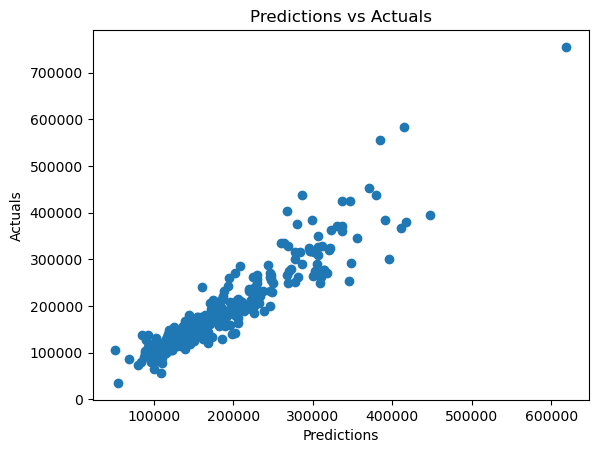

In [39]:
plt.scatter(preds_2,y_test)
plt.title("Predictions vs Actuals")
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.show()